In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sqlalchemy as db
import csv

from pathlib import Path
import matplotlib.pyplot as plt
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Integer, Table, Column, MetaData
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [2]:
# Create SQLite db
restaurants_db = "restaurants.sqlite"
connector = (f"sqlite:///{restaurants_db}")

# Create engine
engine = create_engine(connector)

# Create metadata access to the object
meta_data = db.MetaData(bind=engine)
db.MetaData.reflect(meta_data)

# # Get the tables from the metadata object
# attributes = meta_data.tables["RestaurantAttributes"]
# restaurants = meta_data.tables["Restaurants"]


In [3]:
# Select data into dataframe
sql_join = r"select RestaurantAttributes.*,stars,review_count,is_mexican_restaurant from RestaurantAttributes inner join Restaurants on RestaurantAttributes.business_id = Restaurants.business_id"

restaurants_df = pd.read_sql(sql_join, engine)
business_id_df = restaurants_df["business_id"]
restaurants_df.pop("business_id")
restaurants_df.pop("change_date")
restaurants_df.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,Alcohol,HasTV,NoiseLevel,Caters,WiFi,...,BestNightsTypeId,BestNightsType,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,stars,review_count,is_mexican_restaurant
0,0,0,0,1,0,no,0,no,0,no,...,0,na,1,1,1,1,1,4.5,3,0
1,0,0,0,0,0,no,0,no,0,no,...,0,na,1,1,1,1,1,3.0,12,0
2,0,0,0,0,0,no,0,no,0,no,...,0,na,1,1,1,1,1,3.5,6,0
3,0,0,1,0,0,no,0,no,0,no,...,0,na,1,1,1,1,1,3.0,8,0
4,0,0,0,1,0,no,0,no,0,no,...,0,na,1,1,1,1,1,3.5,25,0


In [4]:
restaurants_df.dtypes

ByAppointmentOnly               int64
BusinessAcceptsCreditCards      int64
GoodForKids                     int64
WheelchairAccessible            int64
BikeParking                     int64
Alcohol                        object
HasTV                           int64
NoiseLevel                     object
Caters                          int64
WiFi                           object
HappyHour                       int64
GoodForDancing                  int64
OutdoorSeating                  int64
CoatCheck                       int64
Smoking                        object
DriveThru                       int64
BYOBCorkage                    object
BusinessParkingTypeId           int64
BusinessParkingType            object
MusicTypeId                     int64
MusicType                      object
RestaurantsTypeId               int64
RestaurantsType                object
GoodForMealTypeId               int64
GoodForMealType                object
DietaryRestrictionsTypeId       int64
DietaryRestr

In [5]:
with pd.option_context('display.max_rows', None,):
    print(restaurants_df.nunique())

for col in restaurants_df:
    print(f"Name: {col} | Values: {restaurants_df[col].unique()}")

ByAppointmentOnly               2
BusinessAcceptsCreditCards      2
GoodForKids                     2
WheelchairAccessible            2
BikeParking                     2
Alcohol                         4
HasTV                           2
NoiseLevel                      4
Caters                          2
WiFi                            3
HappyHour                       2
GoodForDancing                  2
OutdoorSeating                  2
CoatCheck                       2
Smoking                         3
DriveThru                       2
BYOBCorkage                     3
BusinessParkingTypeId           6
BusinessParkingType             6
MusicTypeId                     3
MusicType                       3
RestaurantsTypeId               6
RestaurantsType                 6
GoodForMealTypeId               7
GoodForMealType                 7
DietaryRestrictionsTypeId       3
DietaryRestrictionsType         3
BestNightsTypeId                3
BestNightsType                  3
AlcoholId     

In [6]:
# drop string cols - they're already encoded in the id cols
#show all columns that have a class of object (i.e. string)
string_cols = restaurants_df.select_dtypes(include=["object"]).columns.tolist()
string_cols

restaurants_df.drop(string_cols, axis=1, inplace=True)
restaurants_df.dtypes

ByAppointmentOnly               int64
BusinessAcceptsCreditCards      int64
GoodForKids                     int64
WheelchairAccessible            int64
BikeParking                     int64
HasTV                           int64
Caters                          int64
HappyHour                       int64
GoodForDancing                  int64
OutdoorSeating                  int64
CoatCheck                       int64
DriveThru                       int64
BusinessParkingTypeId           int64
MusicTypeId                     int64
RestaurantsTypeId               int64
GoodForMealTypeId               int64
DietaryRestrictionsTypeId       int64
BestNightsTypeId                int64
AlcoholId                       int64
NoiseLevelId                    int64
WiFiId                          int64
SmokingId                       int64
BYOBCorkageId                   int64
stars                         float64
review_count                    int64
is_mexican_restaurant           int64
dtype: objec

In [7]:
print(restaurants_df.stars.value_counts())
restaurants_df.stars.describe()

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


count    13848.000000
mean         3.422516
std          0.748382
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64

3.5    3581
4.0    3194
3.0    2950
2.5    1485
4.5    1363
2.0     678
5.0     333
1.5     209
1.0      55
Name: stars, dtype: int64


<AxesSubplot:ylabel='Density'>

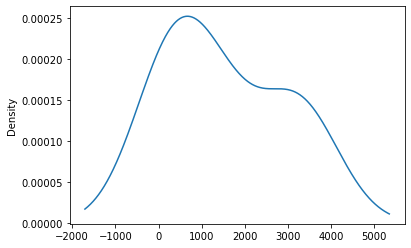

In [8]:
# Visualize the value counts of stars
stars_counts = restaurants_df.stars.value_counts()
print(stars_counts)

stars_counts.plot.density()

In [9]:
# convert stars to categories
model_df = restaurants_df.copy()
# Convert the target column values to low_risk and high_risk based on their values
x = dict.fromkeys([4.0,4.5], 1) # positive review
model_df["stars"] = model_df["stars"].replace(x)

x = dict.fromkeys([1.0, 1.5, 2.0, 2.5,3.0,3.5], 0) # neutral or negative review
model_df["stars"] = model_df["stars"].replace(x)

model_df.reset_index(inplace=True, drop=True)


model_df.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,HasTV,Caters,HappyHour,GoodForDancing,OutdoorSeating,...,DietaryRestrictionsTypeId,BestNightsTypeId,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,stars,review_count,is_mexican_restaurant
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0.0,3,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0.0,12,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0.0,6,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0.0,8,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0.0,25,0


In [10]:
corrs = abs(model_df.corr())["stars"].sort_values(ascending=False)
corrs

# No data point has a direct correlation to the stars

stars                         1.000000
BusinessParkingTypeId         0.061646
Caters                        0.051486
review_count                  0.040673
WheelchairAccessible          0.039249
ByAppointmentOnly             0.037340
GoodForDancing                0.034564
RestaurantsTypeId             0.031016
OutdoorSeating                0.029846
CoatCheck                     0.025071
AlcoholId                     0.019442
DriveThru                     0.014238
WiFiId                        0.013912
SmokingId                     0.013141
DietaryRestrictionsTypeId     0.008592
GoodForMealTypeId             0.007568
BYOBCorkageId                 0.006938
BusinessAcceptsCreditCards    0.006540
is_mexican_restaurant         0.006227
HappyHour                     0.005970
GoodForKids                   0.005674
BikeParking                   0.005574
NoiseLevelId                  0.005339
HasTV                         0.003748
BestNightsTypeId              0.002725
MusicTypeId              

In [11]:
model_df.info()

# No nulls, the only string is the business_id; stars is still a float and needs to be categorized

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13848 entries, 0 to 13847
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ByAppointmentOnly           13848 non-null  int64  
 1   BusinessAcceptsCreditCards  13848 non-null  int64  
 2   GoodForKids                 13848 non-null  int64  
 3   WheelchairAccessible        13848 non-null  int64  
 4   BikeParking                 13848 non-null  int64  
 5   HasTV                       13848 non-null  int64  
 6   Caters                      13848 non-null  int64  
 7   HappyHour                   13848 non-null  int64  
 8   GoodForDancing              13848 non-null  int64  
 9   OutdoorSeating              13848 non-null  int64  
 10  CoatCheck                   13848 non-null  int64  
 11  DriveThru                   13848 non-null  int64  
 12  BusinessParkingTypeId       13848 non-null  int64  
 13  MusicTypeId                 138

In [12]:
target = ["stars"]

columns = model_df.columns.values.tolist()
columns.remove(target[0])
columns.remove("review_count") # Dropped this column because it creates bias
columns

['ByAppointmentOnly',
 'BusinessAcceptsCreditCards',
 'GoodForKids',
 'WheelchairAccessible',
 'BikeParking',
 'HasTV',
 'Caters',
 'HappyHour',
 'GoodForDancing',
 'OutdoorSeating',
 'CoatCheck',
 'DriveThru',
 'BusinessParkingTypeId',
 'MusicTypeId',
 'RestaurantsTypeId',
 'GoodForMealTypeId',
 'DietaryRestrictionsTypeId',
 'BestNightsTypeId',
 'AlcoholId',
 'NoiseLevelId',
 'WiFiId',
 'SmokingId',
 'BYOBCorkageId',
 'is_mexican_restaurant']

In [13]:
# subset and scale data using Z-Scores
df_model = model_df.loc[:, columns]

scaler = StandardScaler().fit(df_model)
df_scale = pd.DataFrame(scaler.transform(df_model), columns=df_model.columns)
df_scale[target] = restaurants_df[target]
df_scale.head()

,ByAppointmentOnly,BusinessAcceptsCreditCards,GoodForKids,WheelchairAccessible,BikeParking,HasTV,Caters,HappyHour,GoodForDancing,OutdoorSeating,...,GoodForMealTypeId,DietaryRestrictionsTypeId,BestNightsTypeId,AlcoholId,NoiseLevelId,WiFiId,SmokingId,BYOBCorkageId,is_mexican_restaurant,stars
0,-0.012019,-0.041667,-0.597925,1.401216,-0.03989,-0.044199,-0.025502,-0.038031,-0.063721,-0.060197,...,-0.13101,-0.036261,-0.017361,-0.16888,-0.034011,-0.017938,-0.083716,-0.044199,-0.288054,4.5
1,-0.012019,-0.041667,-0.597925,-0.713666,-0.03989,-0.044199,-0.025502,-0.038031,-0.063721,-0.060197,...,-0.13101,-0.036261,-0.017361,-0.16888,-0.034011,-0.017938,-0.083716,-0.044199,-0.288054,3.0
2,-0.012019,-0.041667,-0.597925,-0.713666,-0.03989,-0.044199,-0.025502,-0.038031,-0.063721,-0.060197,...,-0.13101,-0.036261,-0.017361,-0.16888,-0.034011,-0.017938,-0.083716,-0.044199,-0.288054,3.5
3,-0.012019,-0.041667,1.672451,-0.713666,-0.03989,-0.044199,-0.025502,-0.038031,-0.063721,-0.060197,...,-0.13101,-0.036261,-0.017361,-0.16888,-0.034011,-0.017938,-0.083716,-0.044199,-0.288054,3.0
4,-0.012019,-0.041667,-0.597925,1.401216,-0.03989,-0.044199,-0.025502,-0.038031,-0.063721,-0.060197,...,-0.13101,-0.036261,-0.017361,-0.16888,-0.034011,-0.017938,-0.083716,-0.044199,-0.288054,3.5


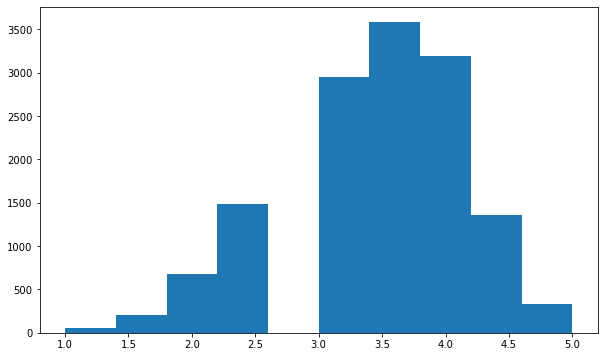

In [14]:
plt.figure(figsize=(10,6))
plt.hist(df_scale[target])
plt.show()

In [15]:
# Segment the features from the target
X = model_df[columns]
y = model_df[target]

In [16]:
# Use the train_test_split function to create training and testing subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(10386, 24)

In [17]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate
brfc = BalancedRandomForestClassifier(n_estimators=25, random_state=1)

# Fit
brfc.fit(X_test, y_test)

BalancedRandomForestClassifier(n_estimators=25, random_state=1)

In [18]:
# Calculated the balanced accuracy score
y_pred_brfc = brfc.predict(X_test)

balanced_accuracy_score(y_test, y_pred_brfc)

0.6541484077773063

In [19]:
# Display the confusion matrix
brfc_matrix = confusion_matrix(y_test, y_pred_brfc)

# Create a DataFrame from the confusion matrix.
# Display the confusion matrix
brfc_matrix = confusion_matrix(y_test, y_pred_brfc)

# Create a DataFrame from the confusion matrix.
brfc_matrix_df = pd.DataFrame(
    brfc_matrix, index=["Actual positive", "Actual negative or neutral"], columns=["Predicted positive", "Predicted negative or neutral"])

brfc_matrix_df

,Predicted positive,Predicted negative or neutral
Actual positive,1286,2093
Actual negative or neutral,6,77


In [20]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brfc))

# Model appears to be overfit given the 100% precision score

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.38      0.93      0.55      0.59      0.33      3379
        5.0       0.04      0.93      0.38      0.07      0.59      0.37        83

avg / total       0.97      0.39      0.91      0.54      0.59      0.33      3462



In [21]:
# List the features sorted in descending order by feature importance
sorted(zip(brfc.feature_importances_, X.columns), reverse=True)

# count of reviews is the most predictive feature; seems like bias
# after dropping review_count, parking and restaurant type are the most important features in the prediction

[(0.39120069954981757, 'BusinessParkingTypeId'),
 (0.13217752662021365, 'RestaurantsTypeId'),
 (0.09511415825009868, 'WheelchairAccessible'),
 (0.08326794384135894, 'is_mexican_restaurant'),
 (0.06739260982586341, 'GoodForMealTypeId'),
 (0.06266888309324693, 'AlcoholId'),
 (0.05082317585594811, 'GoodForKids'),
 (0.01990147036241071, 'OutdoorSeating'),
 (0.019833971967559195, 'SmokingId'),
 (0.016620141888516196, 'ByAppointmentOnly'),
 (0.016192046025948318, 'DriveThru'),
 (0.012994640823130099, 'WiFiId'),
 (0.0051770049437023305, 'GoodForDancing'),
 (0.0046667245750582655, 'BusinessAcceptsCreditCards'),
 (0.0041262497400984385, 'BikeParking'),
 (0.003859489775812676, 'HasTV'),
 (0.0036395936867194495, 'DietaryRestrictionsTypeId'),
 (0.003141928278548312, 'BYOBCorkageId'),
 (0.0026175032951698918, 'HappyHour'),
 (0.001815803106836236, 'Caters'),
 (0.0014310729412212045, 'BestNightsTypeId'),
 (0.0013373615527213579, 'NoiseLevelId'),
 (0.0, 'MusicTypeId'),
 (0.0, 'CoatCheck')]

In [22]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier

eec = EasyEnsembleClassifier(n_estimators=25,random_state=1)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=25, random_state=1)

In [23]:
# Calculated the balanced accuracy score
y_pred_eec = eec.predict(X_test)

balanced_accuracy_score(y_test, y_pred_eec)

0.6112006475145922

In [24]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_eec)

# Display the confusion matrix
eec_matrix = confusion_matrix(y_test, y_pred_eec)

# Create a DataFrame from the confusion matrix.
eec_matrix_df = pd.DataFrame(
    eec_matrix, index=["Actual positive", "Actual negative or neutral"], columns=["Predicted positive", "Predicted negative or neutral"])

eec_matrix_df

,Predicted positive,Predicted negative or neutral
Actual positive,1525,1854
Actual negative or neutral,19,64


In [25]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.45      0.77      0.62      0.59      0.34      3379
        5.0       0.03      0.77      0.45      0.06      0.59      0.36        83

avg / total       0.96      0.46      0.76      0.61      0.59      0.34      3462



In [26]:
df = pd.DataFrame(list(zip(columns, np.mean([est.steps[1][1].feature_importances_ for est in eec.estimators_], axis=0))),
               columns =['Attribute', 'Importance'])

df.sort_values(by=['Importance'], ascending=False)

# Again, review count seems to be the most important feature.  
# Seems like the most predictive element is whether a restaurant has a lot of reviews 
# After dropping review_count, parking and restaurant type are the most important features in the prediction
# EEC seems to weight restaruant type over parking type, though, which is opposite of brfc

,Attribute,Importance
14,RestaurantsTypeId,0.3768
12,BusinessParkingTypeId,0.2216
18,AlcoholId,0.0720
3,WheelchairAccessible,0.0368
15,GoodForMealTypeId,0.0352
2,GoodForKids,0.0344
8,GoodForDancing,0.0320
9,OutdoorSeating,0.0232
23,is_mexican_restaurant,0.0224
6,Caters,0.0200
